# Identification of Factors Generating Time and Cost Deviation in Competitive Bids for Construction Rural Roads in Colombia

The purpose of this notebook is to present the data analysis workflow that allows identifying the factors that generate deviations in time and cost in tenders for construction projects of rural roads in Colombia, from the open data of public contracting registered in the SECOP I platform. This is part of the doctoral [Identification of Factors Generating Time and Cost Deviation in Construction Projects: a Case Study in Rural Roads in Colombia](https://repositorio.uniandes.edu.co/handle/1992/52996) by Adriana Gomez.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# 1. Framework general


![](images/detailed-research-method.png)

# 2. Definition of target projects and data collection (ETL)

La adquisición y procesamiento de los datos se realiza siguiendo el proceso ETL:
- __Extract:__ definición de los contratos objeto de estudio y adquisición de los datos de dichos proyectos de la base de datos SECOP I.
- __Transform:__ cálculo, estandarización y limpieza de los atributos de los contratos seleccionados.
- __Load:__ transformación de los datos extraídos y consolidación en una tabla maestra, la cual es insumo de los análisis posteriores.

![](images/ETL.png)

__Sistema Electrónico de Compra Pública__

Los datos para el estudio se obtuvieron de la base de datos del _Sistema Electrónico de Compra Pública -SECOP-_. Este sistema es administrado por Colombia Compra Eficiente -CCE-, que es la Agencia de Contratación Pública del Gobierno de Colombia. Para el registro y gestión de los procesos de contratación se tienen dos sistemas: SECOP I y SECOP II. El primero, es la versión más antigua del sistema y se utiliza solo para el registro de los contratos. La segunda, es un sistema transaccional en el cual no solo se registran los contratos, si no, que se llevan a cabo procesos de adjudicación, subastas, entre otros. 

Para este estudio se tomó la base de datos SECOP I, la cual está compuesta de una serie de tablas que contienen información de los procesos de contratación, las adiciones de los contratos, los planes anuales de adquisición de las entidades, las multas y sanciones y los oferentes de los procesos. Para la investigación se tomó la tabla de Procesos de Contratación. Esta tabla contiene un total de 73 atributos del contrato lo cual incluye información de:

- La entidad pública (nit, nombre, nivel, orden, ubicación)
- El proceso de contratación (régimen, tipo de proceso, estado, ID)
- El objeto del contrato (tipo de contrato, objeto, clasificación del objeto según el catálogo UNSPSC)
- Valor del contrato (valor del proceso, valor de contrato, adiciones, moneda)
- Fecha y plazos (cargue en SECOP, firma, inicio, finalización, plazo en días o meses, adiciones en obra)
- Contratista (ID, razon social, representante legal, ubicación)
- Otros 

## 2.1 Adquisición de datos (Extract)

El proceso de adquisición de los datos del SECOP I se divide en dos partes:

- _Extracción de datos estructurados:_ se realiza a través de una consulta donde se aplican filtros que permiten seleccionar los contratos (filas) y atributos (columnas) que son parte del objeto de estudio.
- _Extracción de datos no estructurados:_ con el inventario de contratos seleccionados en la extracción de datos estructurados se realiza una búsqueda de información de interés que se encuentra contenida en la documentación de los contratos.

A continuación, se describe con mayor detalle cada una de estos pasos.

### 2.1.1 Adquisición de datos estructurados
 
Los datos estructurados se extrajeron principalmente de la base de datos de procesos de contratación en donde se encuentran almacenadas las variables del contrato que son objeto de la investigación. A continuación, se describen los criterios utilizados para la selección de los atributos y los contratos:
 
__Selección de atributos (columnas)__
 
En función de las preguntas de investigación se seleccionan los atributos del contratos que se desean analizar:
 
- Información de la entidad: nombre de la entidad, orden y nivel de entidad, ubicación geográfica (departamento y municipio).
- Proceso de contratación: régimen y tipo de proceso de contratación
- Objeto del contrato: clasificación del objeto y detalle del objeto
- Valor del contrato: cuantía del proceso, cuantía del contrato, adiciones en la cuantía y valor total con adiciones
- Fechas y Plazos del contrato: fecha de firma, fecha de inicio y finalización, plazo de ejecución y adiciones en tiempo
 
__Selección de contratos (filas)__
 
Teniendo en cuenta que la investigación está enfocada en vías rurales, a continuación se listan los filtros aplicados a los datos:
 
- Fecha de firma del contrato: entre 2014 hasta febrero de 2020
- Tipo de contrato: obra, código de la familia = 9511 (según clasificación UNSPSC)
- Cuantía del proceso y del contrato: >= $20.000.000
- Régimen de contratación: se excluyen contratos de régimen especial
- Tipo de proceso: se incluyeron sólo procesos competitivos (solo licitaciones)
- Estado del contrato: se incluyen solo contratos terminados y liquidados
- Objeto del contrato: se excluyen los contratos cuyo objeto incluye terminos como: suministro de mezcla asfáltica; señalización horizontal; construcción de reductores de velocidad, barandas, muros de contención; demolición; restauración estación férrea; señalización; rehabilitación y conservación puente; mantenimiento túnel; alcantarilla; mano de obra; Box culvert; puentes colgantes; casco urbano; vías urbanas; ejercito; semaforización; demoliciones; muro; ciclovias o cicloruta; residuos sólidos; desmonte y limpieza; y aulas.

### 2.1.2 Adquisición de datos no estructurados

Gran parte de la información de la planeación del contrato, el diseño del proceso y la evaluación de oferentes no se encuentra estructutara y almacenada en tablas de metadadatos. Por esta razon, a partir de los contrato seleccionados se realizó una busqueda manual de la inforamción en documentos como: pliegos, informes de evaluación, contratos y documentos de modificación del contrato. A continuación, se listan las variables extraidas de estos documentos. 

For the project initiation phase, two variables:

- Time studies contract
- IDI: Integral performance index for municipalities

For the project planning phase, seventeen new variables related to the contractual process:

- Advanced payment
- Experience
- Contracting capacity
- Liquidity index
- Debt index
- Interest coverage ratio 
- ROE
- ROA
- Working capital
- Net equity
- Number of bidders

This phase also included four additional variables related to the qualification of the bidders, consisting of the percentage assigned to each of the four aspects allowed by Colombian law (Decreto 1510 de 2013 - EVA - Función Pública, 2013):

- Technical score
- Price score
- National industry score
- Other score

This phase included two additional variables considering the category for which the highest and the lowest scores were assigned in the bidding:

- Lowest score
- Highest score

Finally, the project execution adds one new variable:
- Time suspended.

In [46]:
# Extraer datos del SECOP
from ETL import extract_data, process_data

In [47]:
raw_data = extract_data()
raw_data.head()

El numero de contratos extraidos: 720


uid                               nombre_de_la_entidad  \
0  15-1-1488216430156    VALLE DEL CAUCA  ALCALDÍA MUNICIPIO DE LA UNIÓN   
1  15-1-1445654095917          ANTIOQUIA  ALCALDÍA MUNICIPIO DE MEDELLÍN   
2   18-21-74068240139        CASANARE  ALCALDÍA MUNICIPIO DE SABANALARGA   
3  17-1-1792116571655  CAQUETÁ  ALCALDÍA MUNICIPIO DE CARTAGENA DEL C...   
4  15-1-1398693847921         BOYACÁ  ALCALDÍA MUNICIPIO DE CHIQUINQUIRÁ   

  departamento_entidad                            orden_entidad  \
0      Valle del Cauca  TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6   
1            Antioquia  TERRITORIAL DISTRITAL MUNICIPAL NIVEL 2   
2             Casanare  TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6   
3              Caquetá  TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6   
4               Boyacá  TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6   

           tipo_de_proceso                       objeto_a_contratar  \
0       Licitación Pública  Terrenos, Edificios, Estructuras y Vías   
1       Licitación Pública  Terrenos, Edificios, Estructuras y Vías   
2  Licitación obra pública  Terrenos, Edificios, Estructuras y Vías   
3       Licitación Pública  Terrenos, Edificios, Estructuras y Vías   
4       Licitación Pública  Terrenos, Edificios, Estructuras y Vías   

                                      detalle_objeto cuantia_proceso  \
0  CONSTRUCCION DE PAVIMENTO RIGIDO EN LA CL 13 C...       285341776   
1  CONFORMACIÓN PARCHEO PAVIMENTACIÓN REPAVIMENTA...      1779588615   
2  REALIZAR LA CONSTRUCCIÓN DE OBRAS DE DRENAJE Y...       279116919   
3  EJECUCION DEL PROGRAMA DE RED DE VIAS TERCIARI...       878217589   
4  MANTENIMIENTO Y REPARCHEO DE VÍAS DEL PERÍMETR...       360000000   

  cuantia_contrato valor_total_de_adiciones valor_contrato_con_adiciones  \
0        285151179                        0                    285151179   
1       1750717720                        0                   1750717720   
2        279010379                 44271346                    323281725   
3        878217589                        0                    878217589   
4        359948173                179897140                    539845313   

  anno_firma  fecha_fima fecha_ini_ejec_contrato plazo_de_ejec_del_contrato  \
0       2015  2015-11-18              2015-12-14                         60   
1       2015  2015-10-09              2015-11-03                          3   
2       2019  2019-02-01              2019-02-01                          4   
3       2017  2017-10-18              2017-10-20                          2   
4       2015  2015-07-22              2015-07-24                         90   

  rango_de_ejec_del_contrato tiempo_adiciones_en_dias  \
0                          D                       30   
1                          M                        0   
2                          M                       15   
3                          M                      248   
4                          D                        0   

  tiempo_adiciones_en_meses fecha_fin_ejec_contrato  
0                         0     2016-03-13 00:00:00  
1                         0     2016-02-03 00:00:00  
2                         0     2019-06-01 00:00:00  
3                         0     2018-08-20 00:00:00  
4                         0     2015-10-22 00:00:00

## 2.2 Transformación, estandarización y limpieza de datos (Transform)
 
Las tareas de transformación, estandarización y limpieza buscan modificar las variables de tal manera que se unifiquen conceptos, corrijan formatos de los datos según el tipo, agrupen categorías de variables nominales, lo cual facilita el análisis y manejo de los datos. En esta parte también se crean variables nuevas con el fin de extraer nueva información y patrones a partir de los datos existentes. A continuación, se describen las tareas aplicadas:
 
### 2.2.1 Transformación y estandarización 

- Plazo del contrato en días: en la base de datos original se puede encontrar el plazo del contrato en días o meses. Para facilitar el análisis se unificó en el plazo en días.
- Escalar el valor de los contratos: para incluir el factor de inflación en los contratos, estos fueron escalados en función del salario mínimo mensual en Colombia -SMMLV- según el año de firma del contrato. Esta transformación se aplicó a la cuantía del proceso, cuantía del contrato, adiciones en la cuantía, valor total con adiciones.
- Estandarizar los formatos de fecha en la estructura año-mes-día (YYYY-MM-DD)
- Estandarizar el orden de la entidad: se asignó una categoría de acuerdo al municipio de la entidad. Esta clasificación la establece el departamento de planeación nacional -DNP- de acuerdo al número de habitantes y sus ingresos.
- Intensidad del proyecto: se crea una variable que relaciona el valor del contrato y la duración.
- Award Growth: se crea variable para estimar la relación entre el valor de la oferta ganadora y el precio base establecido para la licitación.
- Clasificar las entidades por región: de acuerdo al departamento de la entidad fue asignada a una de las cinco regiones de Colombia.
- Suspensión del contrato: se crea un variable que indica la duración de la suspensión del contrato como un porcentaje de la duración estimada.
- Desviación en costo y desviación en tiempo: se crearon dos variables de salida asociadas a las desviaciones en costo y tiempo para cada uno de los contratos. Para esto se utilizaron las siguientes fórmulas:
 
$$
\text{Desviación en costo} = \frac{\text{Valor final del contrato - Valor inicial del contrato}}{\text{Valor inicial del contrato}}
$$
 
$$
\text{Desviación en tiempo} = \frac{\text{Plazo final del contrato - Plazo inicial del contrato}}{\text{Plazo inicial del contrato}}
$$

In [48]:
proc_data = process_data(raw_data)
proc_data.head()

CONTRACT_ID                                        ENTITY_NAME  \
0  15-1-1488216430156    VALLE DEL CAUCA  ALCALDÍA MUNICIPIO DE LA UNIÓN   
1  15-1-1445654095917          ANTIOQUIA  ALCALDÍA MUNICIPIO DE MEDELLÍN   
2   18-21-74068240139        CASANARE  ALCALDÍA MUNICIPIO DE SABANALARGA   
3  17-1-1792116571655  CAQUETÁ  ALCALDÍA MUNICIPIO DE CARTAGENA DEL C...   
4  15-1-1398693847921         BOYACÁ  ALCALDÍA MUNICIPIO DE CHIQUINQUIRÁ   

        DEPARTMENT MUNICIPALITY_TYPE             PROCESS_TYPE  \
0  VALLE DEL CAUCA            TYPE_6       LICITACIÓN PÚBLICA   
1        ANTIOQUIA            TYPE_2       LICITACIÓN PÚBLICA   
2         CASANARE            TYPE_6  LICITACIÓN OBRA PÚBLICA   
3          CAQUETÁ            TYPE_6       LICITACIÓN PÚBLICA   
4           BOYACÁ            TYPE_6       LICITACIÓN PÚBLICA   

                           CONTRACT_OBJECT  \
0  TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS   
1  TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS   
2  TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS   
3  TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS   
4  TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS   

                                       OBJETC_DETAIL  ESTIMATED_COST  \
0  CONSTRUCCION DE PAVIMENTO RIGIDO EN LA CL 13 C...      442.836620   
1  CONFORMACIÓN PARCHEO PAVIMENTACIÓN REPAVIMENTA...     2761.835361   
2  REALIZAR LA CONSTRUCCIÓN DE OBRAS DE DRENAJE Y...      337.050509   
3  EJECUCION DEL PROGRAMA DE RED DE VIAS TERCIARI...     1190.453235   
4  MANTENIMIENTO Y REPARCHEO DE VÍAS DEL PERÍMETR...      558.702568   

   CONTRACT_VALUE  ADDITIONAL_COST   FINAL_COST  YEAR CONTRACT_DATE  \
0      442.540823         0.000000   442.540823  2015    2015-11-18   
1     2717.029130         0.000000  2717.029130  2015    2015-10-09   
2      336.921855        53.460320   390.382175  2019    2019-02-01   
3     1190.453235         0.000000  1190.453235  2017    2017-10-18   
4      558.622135       279.191651   837.813786  2015    2015-07-22   

  START_DATE  ORIGINAL_DEADLINE   END_DATE  ADDITIONAL_TIME  FINAL_DEADLINE  \
0 2015-12-14                 60 2016-03-13               30              90   
1 2015-11-03                 90 2016-02-03                0              90   
2 2019-02-01                120 2019-06-01               15             135   
3 2017-10-20                 60 2018-08-20              248             308   
4 2015-07-24                 90 2015-10-22                0              90   

   PROJECT_INTENSITY  AWARD_GROWTH  COST_DEVIATION  TIME_DEVIATION  \
0           7.375680     -0.066796        0.000000        0.500000   
1          30.189213     -1.622335        0.000000        0.000000   
2           2.807682     -0.038170        0.158673        0.125000   
3          19.840887      0.000000        0.000000        4.133333   
4           6.206913     -0.014396        0.499786        0.000000   

          OWNER     REGION  
0  MUNICIPALITY   PACIFICA  
1  MUNICIPALITY     ANDINA  
2  MUNICIPALITY  ORINOQUIA  
3  MUNICIPALITY   AMAZONIA  
4  MUNICIPALITY     ANDINA

### 2.2.2 Limpieza de datos (Reviewing data quality)

Algunas aspectos básicos a revisar para garantizar la calidad de los datos son:
- Duplicados
- Datos faltantes
- Validez y consistencia
    - Consitencia en las fechas: Fecha de terminación < fecha de inicio < fecha de firma
    - Restricciones de ley sobre las adiciones: Desviación en costo debe ser inferior al 50%
    - *Restricciones de ley sobre la duración y valores de los contratos*
- Errores
    - Cuantías y adiciones en valor
    - Plazos y adiciones en tiempo
    - Moneda
    - Objeto
    - Clasificación del contrato

#### Revisar duplicados

In [49]:
# Check duplicates
proc_data.duplicated().sum()

2

In [50]:
# Show all duplicates
proc_data[proc_data.duplicated()]

CONTRACT_ID                                 ENTITY_NAME  \
644  19-21-1495310252385         BOYACÁ  ALCALDÍA MUNICIPIO DE COPER   
652   19-21-131779197268  CUNDINAMARCA  ALCALDÍA MUNICIPIO DE MADRID   

       DEPARTMENT MUNICIPALITY_TYPE             PROCESS_TYPE  \
644        BOYACÁ            TYPE_6  LICITACIÓN OBRA PÚBLICA   
652  CUNDINAMARCA            TYPE_5  LICITACIÓN OBRA PÚBLICA   

                             CONTRACT_OBJECT  \
644  TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS   
652  TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS   

                                         OBJETC_DETAIL  ESTIMATED_COST  \
644  MEJORAMIENTO DE VÍAS CON PAVIMENTO EN ADOQUIN ...      393.718622   
652  MEJORAMIENTO DE ANDENES EN EL BARRIO CEREZOS I...      449.278665   

     CONTRACT_VALUE  ADDITIONAL_COST  FINAL_COST  YEAR CONTRACT_DATE  \
644      438.347251              0.0  438.347251  2020    2020-01-13   
652      449.258100              0.0  449.258100  2019    2019-11-08   

    START_DATE  ORIGINAL_DEADLINE   END_DATE  ADDITIONAL_TIME  FINAL_DEADLINE  \
644 2020-02-13                 90 2020-05-13                0              90   
652 2019-11-14                 90 2020-02-14                0              90   

     PROJECT_INTENSITY  AWARD_GROWTH  COST_DEVIATION  TIME_DEVIATION  \
644           4.870525     11.335158             0.0             0.0   
652           4.991757     -0.004577             0.0             0.0   

            OWNER  REGION  
644  MUNICIPALITY  ANDINA  
652  MUNICIPALITY  ANDINA

In [51]:
# Drop duplicates
proc_data.drop_duplicates(inplace=True)

#### Datos faltantes

In [52]:
# Check missing values
proc_data.isnull().sum()

CONTRACT_ID          0
ENTITY_NAME          0
DEPARTMENT           0
MUNICIPALITY_TYPE    0
PROCESS_TYPE         0
CONTRACT_OBJECT      0
OBJETC_DETAIL        0
ESTIMATED_COST       0
CONTRACT_VALUE       0
ADDITIONAL_COST      0
FINAL_COST           0
YEAR                 0
CONTRACT_DATE        0
START_DATE           0
ORIGINAL_DEADLINE    0
END_DATE             0
ADDITIONAL_TIME      0
FINAL_DEADLINE       0
PROJECT_INTENSITY    0
AWARD_GROWTH         0
COST_DEVIATION       0
TIME_DEVIATION       0
OWNER                0
REGION               0
dtype: int64

#### Errores en las cuantías

Algunas reglas para verificar errores son:
- Valores atípicos
- Valores altos o bajos en el _AWARD_GROWTH__, lo que implica diferencias significativas entre el _ESTIMATED_COST_ y el _CONTRACT_VALUE_.
- Valores altos o bajos en el _COST_DEVIATION_ y el _TIME_DEVIATION_, lo que significa que la relación entre el _CONTRACT_VALUE_ y el FINAL_COST, o _ORIGINAL_DEADLINE_ y  el _FINAL_DEADLINE_ super valores esperados por el tipo de contrato o los topes establecidos por ley.

In [53]:
proc_data.AWARD_GROWTH.describe()

count     718.000000
mean       19.173549
std       515.392452
min       -98.662772
25%        -0.887380
50%        -0.036460
75%        -0.000638
max      9868.015457
Name: AWARD_GROWTH, dtype: float64

In [54]:
# Valores atípicos
# Boxplots for AWARD_GROWTH
#fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 5))
#sns.boxplot(x='AWARD_GROWTH', data=proc_data, ax=axs[0])
#axs[0].set_title('AWARD_GROWTH distribution')
#sns.histplot(x='AWARD_GROWTH', data=proc_data, ax=axs[1])
#plt.show()


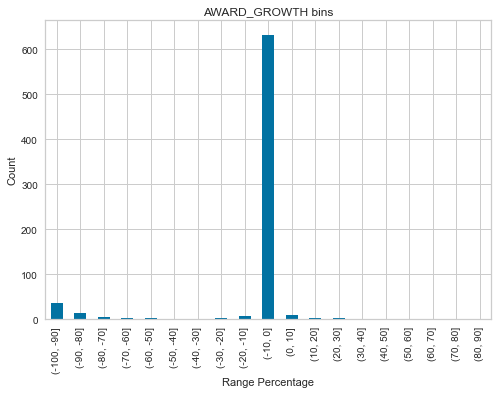

In [55]:
# Bins for AWARD_GROWTH
bins = np.arange(-100, 100, 10)
AWARD_GROWTH_BINS = pd.cut(proc_data['AWARD_GROWTH'], bins)
AWARD_GROWTH_BINS.value_counts(sort=False).plot(kind='bar')
plt.title('AWARD_GROWTH bins')
plt.xlabel('Range Percentage')
plt.ylabel('Count')
plt.show()

In [56]:
# Filter AWARD_GROWTH less than -50 or greater 50
proc_data[(proc_data.AWARD_GROWTH < -50) | (proc_data.AWARD_GROWTH > 50)]

CONTRACT_ID                                ENTITY_NAME  \
7    15-1-1467833988717       META  ALCALDÍA MUNICIPIO DE LEJANÍAS   
14   15-1-1488875060903  ANTIOQUIA  ALCALDÍA MUNICIPIO DE RIONEGRO   
24   16-1-1618435203605          INSTITUTO NACIONAL DE VÍAS INVIAS   
31   16-1-1619755282995          INSTITUTO NACIONAL DE VÍAS INVIAS   
33   17-1-1698356469370                        CALDAS  GOBERNACIÓN   
..                  ...                                        ...   
630  17-1-1698356427467                        CALDAS  GOBERNACIÓN   
691  17-1-1698356436125                        CALDAS  GOBERNACIÓN   
707  16-1-1618435203528          INSTITUTO NACIONAL DE VÍAS INVIAS   
710  16-1-1619755289994          INSTITUTO NACIONAL DE VÍAS INVIAS   
718  16-1-1618435203961          INSTITUTO NACIONAL DE VÍAS INVIAS   

      DEPARTMENT MUNICIPALITY_TYPE        PROCESS_TYPE  \
7           META            TYPE_6  LICITACIÓN PÚBLICA   
14     ANTIOQUIA            TYPE_2  LICITACIÓN PÚBLICA   
24   BOGOTÁ D.C.             OTHER  LICITACIÓN PÚBLICA   
31   BOGOTÁ D.C.             OTHER  LICITACIÓN PÚBLICA   
33        CALDAS             OTHER  LICITACIÓN PÚBLICA   
..           ...               ...                 ...   
630       CALDAS             OTHER  LICITACIÓN PÚBLICA   
691       CALDAS             OTHER  LICITACIÓN PÚBLICA   
707  BOGOTÁ D.C.             OTHER  LICITACIÓN PÚBLICA   
710  BOGOTÁ D.C.             OTHER  LICITACIÓN PÚBLICA   
718  BOGOTÁ D.C.             OTHER  LICITACIÓN PÚBLICA   

                             CONTRACT_OBJECT  \
7    TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS   
14   TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS   
24   TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS   
31   TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS   
33   TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS   
..                                       ...   
630  TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS   
691  TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS   
707  TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS   
710  TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS   
718  TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS   

                                         OBJETC_DETAIL  ESTIMATED_COST  \
7    CONSTRUCCIÓN VIAS URBANAS EN EL MUNICIPIO DE L...     1237.055537   
14   OBRAS DE ESTABILIZACION MITIGACION Y COMPLEMEN...      584.140961   
24   MANTENIMIENTO RUTINARIO VIAS A CARGO DEL INSTI...    19053.356627   
31   MANTENIMIENTO RUTINARIO VIAS A CARGO DEL INSTI...    10193.634371   
33   MEJORAMIENTO MEDIANTE LA CONSTRUCCIÓN DE HUELL...     4323.755187   
..                                                 ...             ...   
630  MEJORAMIENTO MEDIANTE LA CONSTRUCCIÓN DE HUELL...     4323.755187   
691  MEJORAMIENTO MEDIANTE LA CONSTRUCCIÓN DE HUELL...     4323.755187   
707  MANTENIMIENTO RUTINARIO VIAS A CARGO DEL INSTI...    19053.356627   
710  MANTENIMIENTO RUTINARIO VIAS A CARGO DEL INSTI...    10193.634371   
718  MANTENIMIENTO RUTINARIO VIAS A CARGO DEL INSTI...    19053.356627   

     CONTRACT_VALUE  ADDITIONAL_COST   FINAL_COST  YEAR CONTRACT_DATE  \
7         86.593125         0.000000    86.593125  2015    2015-10-08   
14       291.983352         0.000000   291.983352  2015    2015-11-09   
24       687.732193       175.698742   863.430935  2016    2016-10-13   
31       823.676391       211.869397  1035.545788  2016    2016-10-21   
33       477.206591         0.000000   477.206591  2017    2017-06-23   
..              ...              ...          ...   ...           ...   
630      483.186158         0.000000   483.186158  2017    2017-06-23   
691      595.695614         0.000000   595.695614  2017    2017-06-27   
707      738.316731       374.657975  1112.974706  2016    2016-10-13   
710      826.647466       212.633379  1039.280845  2016    2016-10-21   
718      686.403081       304.955017   991.358097  2016    2016-10-14   

    START_DATE  ORIGINAL_DEADLINE   END_DATE  ADDITIONAL_TIME  FINAL_DEADLINE  \
7   2015-10-23                 75 2016-01-06      

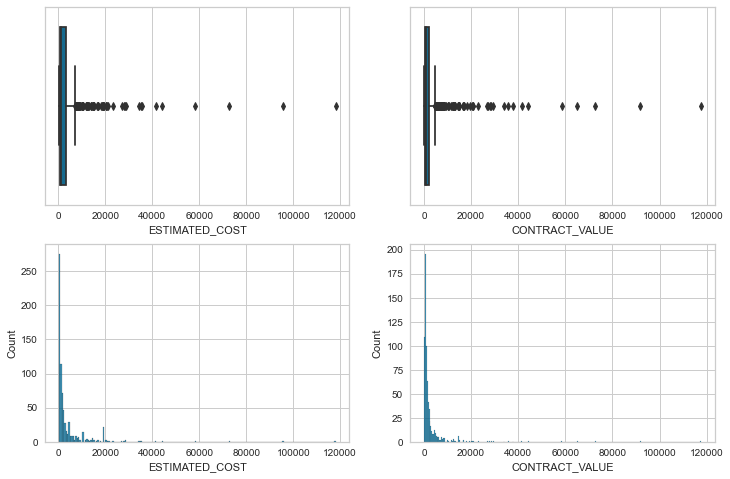

In [57]:
# ESTIMATED_COST and CONTRACT_VALUE distribution with boxplots and histograms
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
sns.boxplot(x='ESTIMATED_COST', data=proc_data, ax=axs[0, 0])
sns.boxplot(x='CONTRACT_VALUE', data=proc_data, ax=axs[0, 1])
sns.histplot(x='ESTIMATED_COST', data=proc_data, ax=axs[1, 0])
sns.histplot(x='CONTRACT_VALUE', data=proc_data, ax=axs[1, 1])
plt.show()

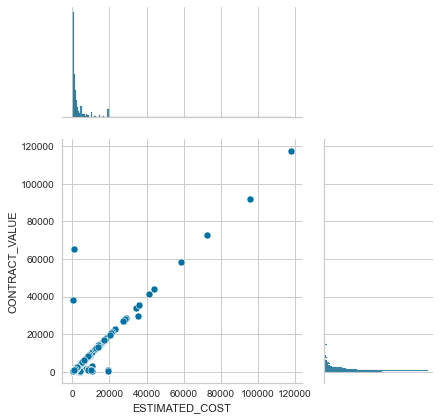

In [58]:
# Relation between ESTIMATED_COST and CONTRACT_VALUE
sns.jointplot(x='ESTIMATED_COST', y='CONTRACT_VALUE',data=proc_data, ratio=2)
plt.show()

#### Plazos, adiciones, fecha de firma y fecha de inicio.

## 2.3 Consolidación de los datos en una tabla maestra (Load)

Todos los datos se consolidan en una tabla maestra, la cual contiene todas las variables transformadas que se utilizaran en el análisis de los datos y el desarrollo de los modelos. Una descripción de los atributos en esta base de datos se presenta a continuación:


<style type="text/css">
.tg  {border-collapse:collapse;border-color:#9ABAD9;border-spacing:0;}
.tg td{background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;
  font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{background-color:#409cff;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#fff;
  font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-cly1{text-align:left;vertical-align:middle}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-cly1">Phase</th>
    <th class="tg-cly1">Variable</th>
    <th class="tg-cly1">Type</th>
    <th class="tg-cly1">Description</th>
    <th class="tg-cly1">Unit/Values</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax" rowspan="10"> 			<br>Project initiation  		</td>
    <td class="tg-0lax"> 			<br>Project type 		</td>
    <td class="tg-0lax">Categorical</td>
    <td class="tg-0lax"> 			<br>The main project object.  		</td>
    <td class="tg-0lax"> 			<br>Construction or Maintenance  		</td>
  </tr>
  <tr>
    <td class="tg-0lax">Owner</td>
    <td class="tg-0lax">Categorical</td>
    <td class="tg-0lax">The entity or the stakeholder responsible for contracting the project. </td>
    <td class="tg-0lax">Amazonia, Andina, Caribe, Orinoquia, or Pacifica </td>
  </tr>
  <tr>
    <td class="tg-0lax">Geographic Location/ Region </td>
    <td class="tg-0lax">Categorical</td>
    <td class="tg-0lax">Colombian regions where the project takes place. </td>
    <td class="tg-0lax">Municipality or Other </td>
  </tr>
  <tr>
    <td class="tg-0lax">Municipality Type </td>
    <td class="tg-0lax">Categorical</td>
    <td class="tg-0lax">Class stated by Colombian law. (According to their number of inhabitants and income).</td>
    <td class="tg-0lax">Type 1 to 6, 1 being the highest category </td>
  </tr>
  <tr>
    <td class="tg-0lax">Period/ Year </td>
    <td class="tg-0lax">Categorical</td>
    <td class="tg-0lax">The period of project execution, in this case, was established in years. </td>
    <td class="tg-0lax">Years: 2015, 2016, 2017, or 2018 </td>
  </tr>
  <tr>
    <td class="tg-0lax">Estimated Cost</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">Budgeted construction cost, determined at the time of procurement by the owner. </td>
    <td class="tg-0lax">Minimum salaries </td>
  </tr>
  <tr>
    <td class="tg-0lax">Original Deadline</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">The project planned duration, determined at the time of procurement by the owner.</td>
    <td class="tg-0lax">Days </td>
  </tr>
  <tr>
    <td class="tg-0lax">Project Intensity </td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">The ratio between the estimated cost and the original deadline. </td>
    <td class="tg-0lax">Minimum salaries/days </td>
  </tr>
  <tr>
    <td class="tg-0lax"> 			<br>Time studies contract 		</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax"> 			<br>Number of days between the publication of previous studies and the signing of the contract 		</td>
    <td class="tg-0lax"> </td>
  </tr>
  <tr>
    <td class="tg-0lax">IDI </td>
    <td class="tg-0lax">N/A</td>
    <td class="tg-0lax">“Indice de Desempeño Integral”: calculated to evaluate public management and decision-making in the use of municipal resources for each municipality in Colombia </td>
    <td class="tg-0lax"> </td>
  </tr>
  <tr>
    <td class="tg-0lax" rowspan="21"> 			<br>Project planning  		</td>
    <td class="tg-0lax"> 			<br>Process Type  		</td>
    <td class="tg-0lax">Categorical</td>
    <td class="tg-0lax"> 			<br>Modality chosen for the contractor procurement and selection.  		</td>
    <td class="tg-0lax"> 			<br>Competitive Bidding, Abbreviated Selection, Minimum Contract  Minimum salaries  		</td>
  </tr>
  <tr>
    <td class="tg-0lax">Contractor</td>
    <td class="tg-0lax">Categorical</td>
    <td class="tg-0lax">The stakeholder responsible for executing the project.</td>
    <td class="tg-0lax">Individual, Consortium, or Companies</td>
  </tr>
  <tr>
    <td class="tg-0lax">Contract Value</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">The contract awarded amount. </td>
    <td class="tg-0lax">Minimum salaries </td>
  </tr>
  <tr>
    <td class="tg-0lax">Award Growth </td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">The ratio between the difference of contract value and the estimated cost. </td>
    <td class="tg-0lax">Percentage (%) </td>
  </tr>
  <tr>
    <td class="tg-0lax"> 			<br>Advanced payment 		</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax"> 			<br>Percentage of the initial cost paid before the start of the project  		</td>
    <td class="tg-0lax"> 			<br>Percentage  		</td>
  </tr>
  <tr>
    <td class="tg-0lax">Experience</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">Value of required executed contracts expressed at present value</td>
    <td class="tg-0lax">--</td>
  </tr>
  <tr>
    <td class="tg-0lax">Contracting capacity (K)</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">The bidder's capacity to perform the contract, taking into account other projects under execution. </td>
    <td class="tg-0lax">--</td>
  </tr>
  <tr>
    <td class="tg-0lax"> 			<br>Liquidity index 		</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax"> 			<br>Current assets over current liabilities  		</td>
    <td class="tg-0lax"> 			<br>--  		</td>
  </tr>
  <tr>
    <td class="tg-0lax">Debt index</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">Total liabilities over total assets </td>
    <td class="tg-0lax">-- </td>
  </tr>
  <tr>
    <td class="tg-0lax">Interest coverage ratio</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">Earnings before interest and taxes over interest expense</td>
    <td class="tg-0lax">-- </td>
  </tr>
  <tr>
    <td class="tg-0lax">Return on Equity – ROE</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">Net income by shareholder's equity </td>
    <td class="tg-0lax">-- </td>
  </tr>
  <tr>
    <td class="tg-0lax">Return on Assets – ROA</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">The ratio between net income and the average total assets.</td>
    <td class="tg-0lax"> </td>
  </tr>
  <tr>
    <td class="tg-0lax">Working capital</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">Current Assets – Current Liabilities </td>
    <td class="tg-0lax">Cash </td>
  </tr>
  <tr>
    <td class="tg-0lax">Net equity</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">Total Assets−Total Liabilities </td>
    <td class="tg-0lax">Cash </td>
  </tr>
  <tr>
    <td class="tg-0lax">Number of bidders</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">Number of bidders participating in the hiring process</td>
    <td class="tg-0lax">Number of bidders</td>
  </tr>
  <tr>
    <td class="tg-0lax">Price score</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">The percentage assigned to price in the evaluation </td>
    <td class="tg-0lax">Percentage </td>
  </tr>
  <tr>
    <td class="tg-0lax">Technical score</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">The percentage assigned to technical aspects in the evaluation</td>
    <td class="tg-0lax">Percentage </td>
  </tr>
  <tr>
    <td class="tg-0lax">National industry</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">The percentage assigned to national industry score in the evaluation </td>
    <td class="tg-0lax">Percentage </td>
  </tr>
  <tr>
    <td class="tg-0lax">Other score</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">The percentage assigned to other aspects in the evaluation</td>
    <td class="tg-0lax">Percentage </td>
  </tr>
  <tr>
    <td class="tg-0lax">Lowest category score</td>
    <td class="tg-0lax">Categorical</td>
    <td class="tg-0lax">The category to which the lowest score has been assigned </td>
    <td class="tg-0lax">Price, technical, national industry, other</td>
  </tr>
  <tr>
    <td class="tg-0lax">Higher category score</td>
    <td class="tg-0lax">Categorical</td>
    <td class="tg-0lax">The category to which the highest score has been assigned</td>
    <td class="tg-0lax">Price, technical, national industry, other </td>
  </tr>
  <tr>
    <td class="tg-0lax" rowspan="5"> 			<br>Project execution and closure  		</td>
    <td class="tg-0lax"> 			<br>Additional Cost (Numerical)  		</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax"> 			<br>The difference between the contract value and the final contract cost.  		</td>
    <td class="tg-0lax"> 			<br>Minimum salaries 		</td>
  </tr>
  <tr>
    <td class="tg-0lax">Additional Time (Numerical) </td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">Difference between the original deadline and the final contract deadline.</td>
    <td class="tg-0lax">Days </td>
  </tr>
  <tr>
    <td class="tg-0lax">Final Cost (Numerical)</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">Final contract cost. </td>
    <td class="tg-0lax">Minimum salaries Days </td>
  </tr>
  <tr>
    <td class="tg-0lax">Final Deadline (Numerical) </td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">Final contract deadline. </td>
    <td class="tg-0lax">Days </td>
  </tr>
  <tr>
    <td class="tg-0lax"> 			<br>Time suspended  		</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">Number of days the project was suspended, expressed as a percentage of the initial deadline </td>
    <td class="tg-0lax">Percentage </td>
  </tr>
</tbody>
</table>

In [57]:
# Cargar tabla maestra de datos
master_data = pd.read_excel('data/master_data.xlsx')
# master_data set index from 1 to n
master_data['NUMBER_OF_CONTRACTS'] = [i for i in range(1, len(master_data) + 1)]
# set index NUMBER_OF_CONTRACTS
master_data.set_index('NUMBER_OF_CONTRACTS', inplace=True)
master_data.head()

COST_DEVIATION  TIME_DEVIATION  TIME_STUDIES_CONTRACT  \
NUMBER_OF_CONTRACTS                                                          
1                              0.18            0.50                  111.0   
2                              0.25            0.00                   38.0   
3                              0.00            0.38                   41.0   
4                              0.00            0.00                   47.0   
5                              0.00            0.00                   35.0   

                     ADVANCED_PAYMENT  ESTIMATED_COST  ORIGINAL_DEADLINE  \
NUMBER_OF_CONTRACTS                                                        
1                                 0.0          861.08                 90   
2                                 0.0          325.26                 90   
3                                 0.4         1084.43                120   
4                                 0.0          358.75                 60   
5                                 0.0         2020.64                 60   

                     LIQUIDITY_INDEX_B  DEBT_INDEX_B  \
NUMBER_OF_CONTRACTS                                    
1                                 10.0          0.50   
2                                 85.0          0.16   
3                                 10.0          0.40   
4                                 25.0          0.50   
5                                250.0          0.15   

                     INTEREST_COVERAGE_RATIO_B  ROE_B  ...       LOWEST_SCORE  \
NUMBER_OF_CONTRACTS                                    ...                      
1                                          1.0   0.05  ...  NATIONAL_INDUSTRY   
2                                         85.0   0.13  ...              OTHER   
3                                         10.0   0.15  ...              OTHER   
4                                          4.0   0.55  ...              OTHER   
5                                          5.0   0.10  ...  NATIONAL_INDUSTRY   

                       YEAR       IDI_CAT  CONTRACT_TYPE  MUNICIPALITY_TYPE  \
NUMBER_OF_CONTRACTS                                                           
1                    Y_2016  SATISFACTORY   CONSTRUCTION             TYPE_6   
2                    Y_2017  SATISFACTORY   MAINTEINANCE             TYPE_6   
3                    Y_2017   OUTSTANDING   MAINTEINANCE             TYPE_6   
4                    Y_2018           LOW   MAINTEINANCE             TYPE_6   
5                    Y_2015  SATISFACTORY   MAINTEINANCE             TYPE_6   

                     DEPARTMENT  REGION        REGION_2         OWNER  \
NUMBER_OF_CONTRACTS                                                     
1                     MAGDALENA  CARIBE          CARIBE  MUNICIPALITY   
2                        BOYACA  ANDINA  CENTRO_ORIENTE  MUNICIPALITY   
3                     ANTIOQUIA  ANDINA    EJE_CAFETERO  MUNICIPALITY   
4                        TOLIMA  ANDINA      CENTRO_SUR  MUNICIPALITY   
5                        BOYACA  ANDINA  CENTRO_ORIENTE  MUNICIPALITY   

                        PERFORMANCE  
NUMBER_OF_CONTRACTS                  
1                              BOTH  
2                    COST_DEVIATION  
3                    TIME_DEVIATION  
4                      NO_DEVIATION  
5                      NO_DEVIATION  

[5 rows x 41 columns]

In [58]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 1 to 204
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   COST_DEVIATION             204 non-null    float64
 1   TIME_DEVIATION             204 non-null    float64
 2   TIME_STUDIES_CONTRACT      203 non-null    float64
 3   ADVANCED_PAYMENT           204 non-null    float64
 4   ESTIMATED_COST             204 non-null    float64
 5   ORIGINAL_DEADLINE          204 non-null    int64  
 6   LIQUIDITY_INDEX_B          204 non-null    float64
 7   DEBT_INDEX_B               204 non-null    float64
 8   INTEREST_COVERAGE_RATIO_B  198 non-null    float64
 9   ROE_B                      201 non-null    float64
 10  ROA_B                      201 non-null    float64
 11  WORKING_CAPITAL            95 non-null     float64
 12  NET_EQUITY                 57 non-null     float64
 13  EXPERIENCE_B_VALUE         197 non-null    float64

# 3. DEVELOPMENT OF EXPLORATORY DATA ANALYSIS


## 3.1 Getting data profile (Pandas profiling)

- Análisis de la distribución, gráficos de cajas y análisis de outliers.
- Análisis correlacional con las variables de desviación en tiempo y costo


In [61]:
from pandas_profiling import ProfileReport

In [62]:
profile = ProfileReport(master_data, title="Pandas Profiling Report")

In [63]:
profile.to_file("pandas_profiling_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 3.2 Missing data

Regarding the completeness of the data, different requirements of the contracting process were identified that are not mandatory in all the bidding processes. See the next Table where _Net equity_ and _Working capital_ with many missing data were not considered in further analysis. These factors are not requested in all bidding processes.

In [59]:
# count missing values
missing_data = (master_data
                .isnull()
                .sum()
                .sort_values(ascending=False)
                .reset_index()
                .rename(columns={'index': 'Variable', 0: 'Count'})
                .query("Count > 0")
                .assign(Porcentaje=lambda x: np.round(((x.Count / master_data.shape[0]) * 100), 2)))
missing_data

Variable  Count  Porcentaje
0                 NET_EQUITY    147       72.06
1            WORKING_CAPITAL    109       53.43
2      K_CONTRACTING_B_VALUE      9        4.41
3         EXPERIENCE_B_VALUE      7        3.43
4  INTEREST_COVERAGE_RATIO_B      6        2.94
5                      ROE_B      3        1.47
6                      ROA_B      3        1.47
7      TIME_STUDIES_CONTRACT      1        0.49

## 3.3 Outliers (PCA - Kmeans)


Para identificar los outliers se desarrollaron los siguientes pasos:
- El eliminaron las variables: CONTRACT_VALUE, FINAL_COST, ROA_B, FINAL_DEADLINE, NET_EQUITY, WORKING_CAPITAL (porque?)
- Se quitaron las variables categóricas
- Se eliminaron filas con valores faltanes
- Se hizo un análisis de cluster con el método Kmeans y se identificaron 5 clusters
- Para visualizar los cluster se hizo una anlisis de componentes principales 
- Se identificaron clusters y contratos que se alejan significativamente de la mayoria de contratos

In [60]:
# Eliminar variables con más de un 50% de valores faltantes
master_data.drop(['NET_EQUITY', 'WORKING_CAPITAL'], axis=1, inplace=True)

In [61]:
# fill missing values with median
for i in master_data.columns:
    if master_data[i].isnull().sum() > 0:
        master_data[i].fillna(master_data[i].median(), inplace=True)

In [64]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

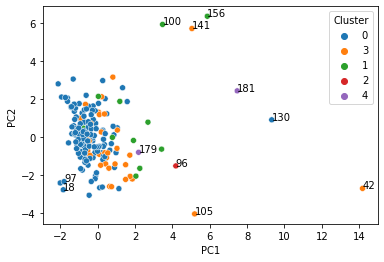

In [65]:
# Create a copy of master_data
master_data_filtered = master_data.copy()

# Delete columns -CONTRACT_VALUE,-FINAL_COST,-ROA_B,-FINAL_DEADLINE,-NET_EQUITY,-WORKING_CAPITAL
master_data_filtered = master_data_filtered.drop(['CONTRACT_VALUE', 'FINAL_COST', 'ROA_B', 'FINAL_DEADLINE'], axis=1)

# Select columns with numeric values
master_data_filtered = master_data_filtered.select_dtypes(include=['number'])

# Delete rows with missing values
master_data_filtered = master_data_filtered.dropna(axis=0)

# cluster with KMeans with data filtered
kmeans = KMeans(n_clusters=5, random_state=0).fit(master_data_filtered)
clusters = kmeans.labels_

pipe_pca = make_pipeline(StandardScaler(), PCA(n_components=2))

# PCA with 2 components
#pca_model = PCA(n_components=2, whiten=True)
pca_data = pipe_pca.fit(master_data_filtered).transform(master_data_filtered)

# convert to pandas dataframe
pca_data = pd.DataFrame(pca_data, columns=['PC1', 'PC2'], index=master_data_filtered.index)
pca_data['Cluster'] = [str(i) for i in clusters]

# plot pca with clusters colors
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_data)

# add text from index
oulier_index = [18, 42, 96, 97, 100, 105, 130, 141, 156, 179, 181]
for i in pca_data.index:
    if i in oulier_index:
        plt.annotate(i, (pca_data.loc[i, 'PC1'], pca_data.loc[i, 'PC2']))
plt.show()

The data profiling reported the presence of outliers. Applying Principal Component Analysis – PCA, complemented with cluster analysis using the K-means method, identified those that correspond to multivariate outliers, considered all the numerical variables. See the last Figure.

In [66]:
# delete rows in outlier_index
master_data = master_data.loc[~master_data.index.isin(oulier_index),].copy()
print(master_data.shape)

(193, 39)


## 3.4 Correlations treatment 

En esta parte se busca identificar las variables independientes que estan altamente correlacionadas utilizando el coeficiente de correlacción de Sperman $\rho$

/var/folders/yb/73r2f0hj06z2_w4y40669q480000gn/T/ipykernel_3606/3156817339.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


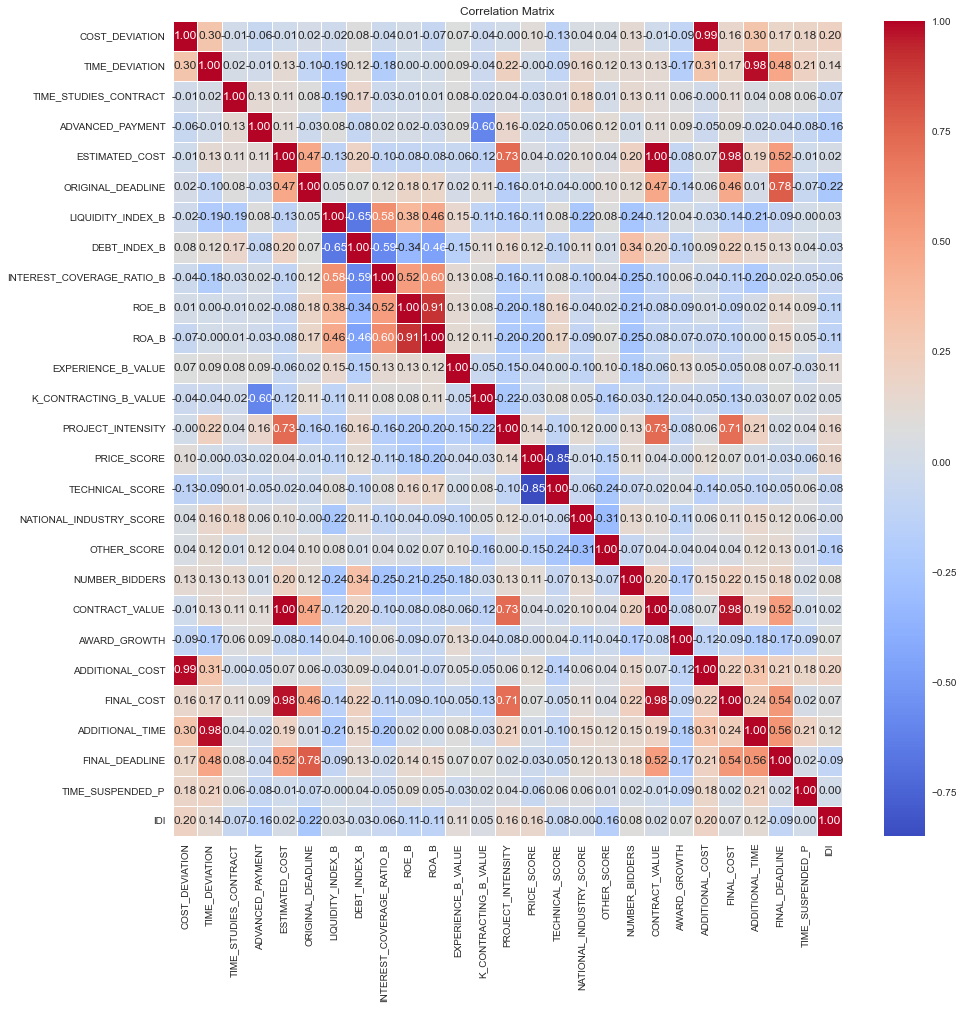

In [80]:
# Matriz de correlación de spearman con las variables numéricas sin COST_DEVIATION and TIME_DEVIATION
#corr_matrix = master_data.drop(columns=['COST_DEVIATION','TIME_DEVIATION']).corr(method='spearman')
corr_matrix = master_data.corr(method='spearman')
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [8]:
500000*4000

2000000000

In [81]:
# Seleccion de variables altamente correlacionadas
#num_cols = master_data.drop(['COST_DEVIATION', 'TIME_DEVIATION'], axis=1).select_dtypes(include=['number']).columns
num_cols = master_data.select_dtypes(include=['number']).columns
correlaciones = []
for i in range(len(num_cols)-1):
    for j in range(i+1, len(num_cols)):
        col_i = num_cols[i]
        col_j = num_cols[j]
        rho, pval = stats.spearmanr(master_data[col_i], master_data[col_j], nan_policy='omit')
        temp = (col_i, col_j, rho, pval)
        correlaciones.append(temp)

correlaciones = pd.DataFrame(correlaciones, columns=['Var1', 'Var2', 'rho', 'p-value'])

In [82]:
threshold = 0.8
correlaciones[correlaciones.rho > threshold].sort_values(by='rho', ascending=False)

Var1             Var2       rho        p-value
112  ESTIMATED_COST   CONTRACT_VALUE  0.999939   0.000000e+00
20   COST_DEVIATION  ADDITIONAL_COST  0.988625  4.186329e-159
47   TIME_DEVIATION  ADDITIONAL_TIME  0.980463  7.700512e-137
325  CONTRACT_VALUE       FINAL_COST  0.977959  6.876254e-132
115  ESTIMATED_COST       FINAL_COST  0.977585  3.375190e-131
198           ROE_B            ROA_B  0.908206   3.553625e-74

## 3.5 Developing the sample characterization

Se hace una análisis por columna según el tipo de variable:

- Variables númericas: media, desviación, mínimo, máximo, data completeness rate
- Varaibles categóricas: frecuencia y proporción


### 3.5.1 Estadísticas descriptivas para variables numericas

In [83]:
master_data.describe()

COST_DEVIATION  TIME_DEVIATION  TIME_STUDIES_CONTRACT  \
count      193.000000      193.000000             193.000000   
mean         0.078635        0.247073              57.466321   
std          0.151459        0.442295              60.664894   
min          0.000000        0.000000              16.000000   
25%          0.000000        0.000000              40.000000   
50%          0.000000        0.000000              49.000000   
75%          0.060000        0.360000              60.000000   
max          0.500000        3.280000             779.000000   

       ADVANCED_PAYMENT  ESTIMATED_COST  ORIGINAL_DEADLINE  LIQUIDITY_INDEX_B  \
count        193.000000      193.000000         193.000000         193.000000   
mean           0.108705     1009.246506         106.533679          22.303782   
std            0.189885      996.350032          74.889920          60.909811   
min            0.000000      237.450000          10.000000           0.620000   
25%            0.000000      421.220000          75.000000           2.300000   
50%            0.000000      642.268738          90.000000           5.500000   
75%            0.200000     1084.430000         120.000000          14.000000   
max            0.500000     5378.164047         900.000000         600.000000   

       DEBT_INDEX_B  INTEREST_COVERAGE_RATIO_B       ROE_B       ROA_B  \
count    193.000000                 193.000000  193.000000  193.000000   
mean       0.478093                  24.382383    0.149135    0.122813   
std        1.426379                  80.180841    0.130010    0.117612   
min        0.010000                   0.000000    0.000000    0.000000   
25%        0.200000                   3.000000    0.070000    0.050000   
50%        0.400000                   9.820000    0.100000    0.100000   
75%        0.500000                  20.000000    0.200000    0.150000   
max       20.000000                1000.000000    1.000000    1.000000   

       EXPERIENCE_B_VALUE  K_CONTRACTING_B_VALUE  PROJECT_INTENSITY  \
count          193.000000             193.000000         193.000000   
mean             2.029000               0.938653          10.082248   
std              1.718689               0.467624           8.723773   
min              0.300000               0.250000           2.410000   
25%              1.000000               0.900000           5.100000   
50%              1.480000               1.000000           6.920000   
75%              2.000000               1.000000          11.160000   
max             11.170000               5.000000          52.270000   

       PRICE_SCORE  TECHNICAL_SCORE  NATIONAL_INDUSTRY_SCORE  OTHER_SCORE  \
count   193.000000       193.000000               193.000000   193.000000   
mean      0.461606         0.398352                 0.091295     0.048798   
std       0.173626         0.180391                 0.042191     0.099566   
min       0.000000         0.000000                 0.000000     0.000000   
25%       0.300000         0.300000                 0.100000     0.000000   
50%       0.500000         0.400000                 0.100000     0.000000   
75%       0.600000         0.500000                 0.100000     0.050000   
max       1.000000         0.900000                 0.300000     0.500000   

       NUMBER_BIDDERS  CONTRACT_VALUE  AWARD_GROWTH  ADDITIONAL_COST  \
count      193.000000      193.000000    193.000000       193.000000   
mean         1.554404     1007.426231     -0.192497        74.889365   
std          1.799419      994.638256      0.700948       222.270758   
min          1.000000      237.450000     -6.545600         0.000000   
25%          1.000000      421.130000     -0.061800         0.000000   
50%          1.000000      641.801259     -0.009300         0.000000   
75%          1.000000     1084.430000     -0.000100        41.130000   
max         16.000000     5377.178864      0.000100      2249.930000   

        FINAL_COST  ADDITIONAL_TIME  FINAL_DEADLIN

/var/folders/yb/73r2f0hj06z2_w4y40669q480000gn/T/ipykernel_3606/852593670.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


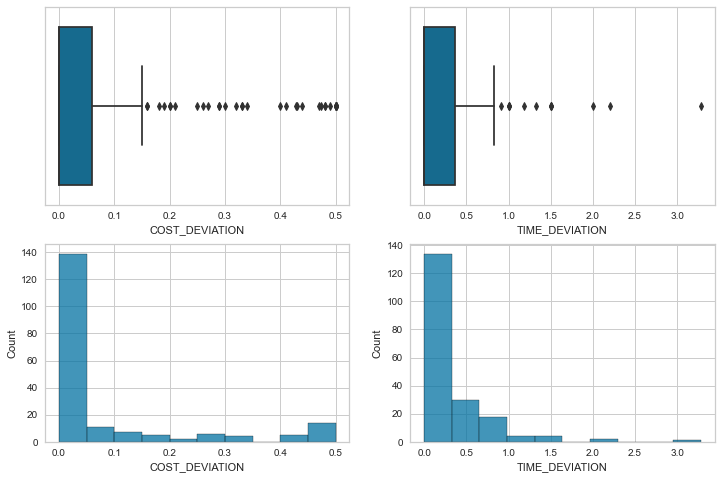

In [84]:
# Dependent variables plot – Competitive bidding projects
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
sns.boxplot(x='COST_DEVIATION', data=master_data, ax=axs[0, 0])
sns.boxplot(x='TIME_DEVIATION', data=master_data, ax=axs[0, 1])
sns.histplot(x='COST_DEVIATION', data=master_data, ax=axs[1, 0], bins=10)
sns.histplot(x='TIME_DEVIATION', data=master_data, ax=axs[1, 1], bins=10)
plt.show()

### 3.5.2 Estadísticas descriptivas para variables categóricas

In [85]:
cat_cols = master_data.select_dtypes(include=['object']).columns
for col in cat_cols:
    sort_col = True
    if col == 'YEAR':
        sort_col = False
    print('-'*50)
    print(col)
    print((master_data[col]
           .value_counts(sort=sort_col)
           .reset_index()
           .rename(columns={'index':col, col:'Count'})
           .assign(Percentage=lambda x: np.round(x['Count']/sum(x['Count'])*100, 2))
          )
         )

--------------------------------------------------
CONTRACTOR
   CONTRACTOR  Count  Percentage
0  CONSORTIUM     77       39.90
1     COMPANY     63       32.64
2  INDIVIDUAL     53       27.46
--------------------------------------------------
HIGHEST SCORE
  HIGHEST SCORE  Count  Percentage
0         PRICE    105       54.40
1     TECHNICAL     72       37.31
2         OTHER     16        8.29
--------------------------------------------------
LOWEST_SCORE
        LOWEST_SCORE  Count  Percentage
0              OTHER    158       81.87
1  NATIONAL_INDUSTRY     35       18.13
--------------------------------------------------
YEAR
     YEAR  Count  Percentage
0  Y_2016     28       14.51
1  Y_2017     49       25.39
2  Y_2018     37       19.17
3  Y_2015     63       32.64
4  Y_2019     16        8.29
--------------------------------------------------
IDI_CAT
        IDI_CAT  Count  Percentage
0  SATISFACTORY     58       30.05
1   OUTSTANDING     58       30.05
2           LOW     49 

/var/folders/yb/73r2f0hj06z2_w4y40669q480000gn/T/ipykernel_3606/550152232.py:40: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


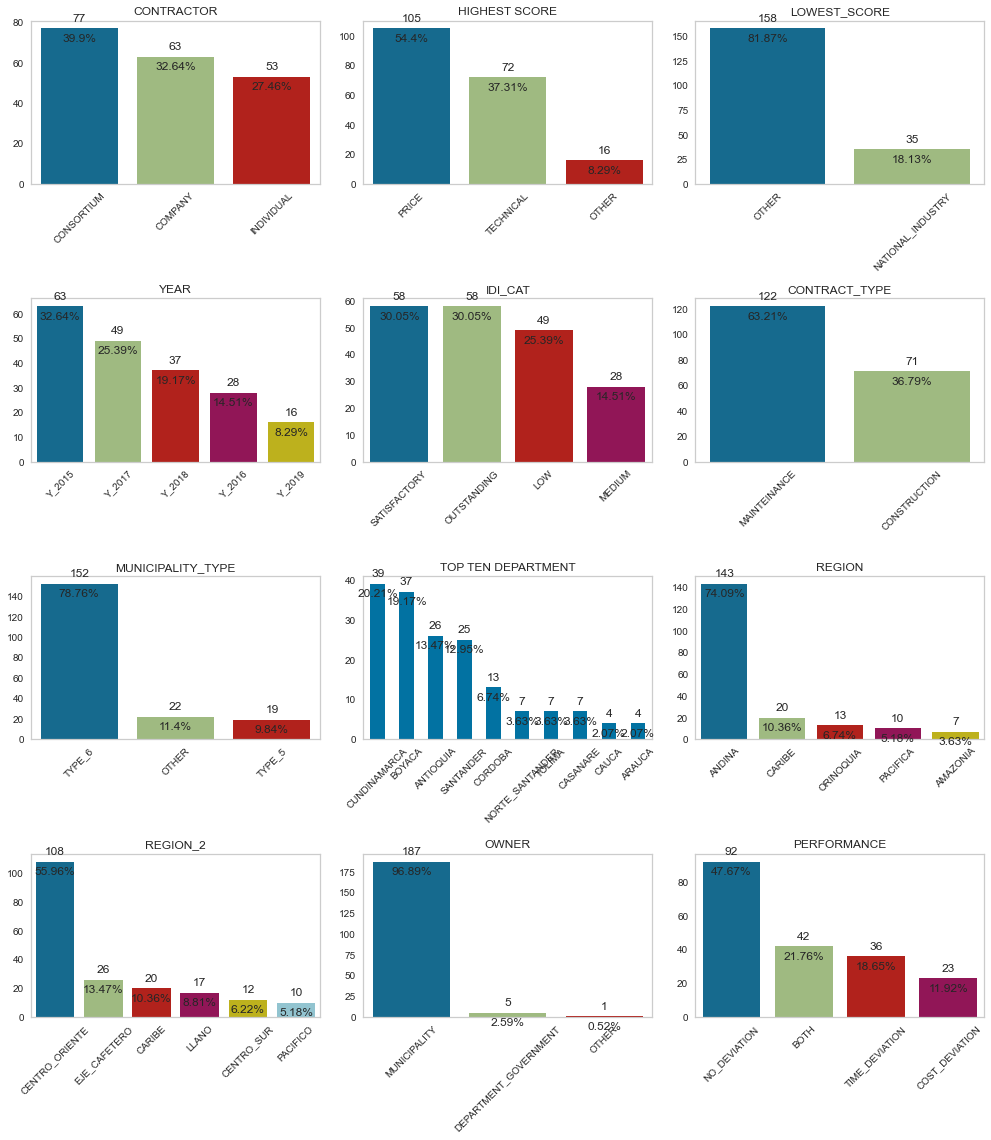

In [86]:
# subplot for categorical values nrows=3, ncols=4
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(14, 16))
for i, col in enumerate(cat_cols):
    if col == 'DEPARTMENT':
        # agregate categories with lower count
        (master_data[col]
        .value_counts(sort=True)
        .head(10)
        .plot(kind='bar', ax=axs[i//3, i%3]))
        axs[i//3, i%3].set_title('TOP TEN ' + col)

    else:
        sns.countplot(x=col, data=master_data, order=master_data[col].value_counts().index, ax=axs[i//3, i%3])
        axs[i//3, i%3].set_title(col)
    
    # add values and percent in barchart
    for p in axs[i//3, i%3].patches:
        axs[i//3, i%3].annotate(
            str(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points')
        axs[i//3, i%3].annotate(
            str(np.round(p.get_height()/sum(master_data[col].value_counts())*100, 2)) + '%',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, -10),
            textcoords='offset points')
        
    # delete grid
    axs[i//3, i%3].grid(False)
    axs[i//3, i%3].set_xticklabels(axs[i//3, i%3].get_xticklabels(), rotation=45)
    axs[i//3, i%3].set_xlabel('')
    # separete plots for each column
    axs[i//3, i%3].set_ylabel('')
plt.tight_layout()
plt.show()

## 4. IDENTIFICATION OF SIGNIFICANT VARIABLES AND ANALYSIS

- Bivariate analysis (Kruska-Wallis test)
- Multivariate analysis (Machine Learning Models and Logistic Regression)
- Comparing results
- Identifying the need for transforming variables
- Evaluating the interest in obtaining the predictive capacity

### 4.1 Bivariate analysis (Kruska-Wallis test and correlation analysis)


In [87]:
# Variables highly Correlated with COST_DEVIATION
correlaciones[correlaciones.Var1 == 'COST_DEVIATION'].sort_values(by='rho', ascending=False).head(10)

Var1              Var2       rho        p-value
20  COST_DEVIATION   ADDITIONAL_COST  0.988625  4.186329e-159
0   COST_DEVIATION    TIME_DEVIATION  0.303739   1.753541e-05
22  COST_DEVIATION   ADDITIONAL_TIME  0.299667   2.298110e-05
25  COST_DEVIATION               IDI  0.200277   5.228435e-03
24  COST_DEVIATION  TIME_SUSPENDED_P  0.183035   1.083921e-02
23  COST_DEVIATION    FINAL_DEADLINE  0.171702   1.695778e-02
21  COST_DEVIATION        FINAL_COST  0.155611   3.069881e-02
17  COST_DEVIATION    NUMBER_BIDDERS  0.130639   7.016128e-02
13  COST_DEVIATION       PRICE_SCORE  0.102508   1.560215e-01
6   COST_DEVIATION      DEBT_INDEX_B  0.077673   2.829682e-01

In [88]:
# Variables highly Correlated with TIME_DEVIATION
correlaciones[correlaciones.Var1 == 'TIME_DEVIATION'].sort_values(by='rho', ascending=False).head(10)

Var1                     Var2       rho        p-value
47  TIME_DEVIATION          ADDITIONAL_TIME  0.980463  7.700512e-137
48  TIME_DEVIATION           FINAL_DEADLINE  0.476602   2.446157e-12
45  TIME_DEVIATION          ADDITIONAL_COST  0.306322   1.474063e-05
37  TIME_DEVIATION        PROJECT_INTENSITY  0.215227   2.647872e-03
49  TIME_DEVIATION         TIME_SUSPENDED_P  0.210641   3.278153e-03
46  TIME_DEVIATION               FINAL_COST  0.173184   1.601642e-02
40  TIME_DEVIATION  NATIONAL_INDUSTRY_SCORE  0.156437   2.981263e-02
50  TIME_DEVIATION                      IDI  0.136869   5.769200e-02
42  TIME_DEVIATION           NUMBER_BIDDERS  0.128770   7.430290e-02
28  TIME_DEVIATION           ESTIMATED_COST  0.127866   7.637681e-02

In [89]:
# select categorical columns
cat_cols = master_data.select_dtypes(include=['object']).columns
for var in cat_cols:
    print("-"*50)
    print("Estadisticas comparativas por la variable {}".format(var))
    print((master_data
            .loc[master_data.COST_DEVIATION >= 0, [var,"COST_DEVIATION"]]
            .groupby(var)
            .describe()
            .T))

--------------------------------------------------
Estadisticas comparativas por la variable CONTRACTOR
CONTRACTOR              COMPANY  CONSORTIUM  INDIVIDUAL
COST_DEVIATION count  63.000000   77.000000   53.000000
               mean    0.084330    0.060439    0.098302
               std     0.160798    0.130353    0.167673
               min     0.000000    0.000000    0.000000
               25%     0.000000    0.000000    0.000000
               50%     0.000000    0.000000    0.000000
               75%     0.062164    0.020000    0.140000
               max     0.500000    0.500000    0.500000
--------------------------------------------------
Estadisticas comparativas por la variable HIGHEST SCORE
HIGHEST SCORE             OTHER       PRICE  TECHNICAL
COST_DEVIATION count  16.000000  105.000000  72.000000
               mean    0.049021    0.095941   0.059978
               std     0.126673    0.163106   0.136684
               min     0.000000    0.000000   0.000000
          

In [91]:
# Kruskal-Wallis test for all categorical variables
print("Prueba de Kruskal-Wallis para todas las variables categóricas con respecto a la desviación en costo")
y_var = "COST_DEVIATION"
kw_test = []
for x_var in cat_cols:
    temp = [group[y_var].values for name, group in master_data.groupby(x_var)]
    K, p = stats.kruskal(*temp)
    kw_test.append((y_var, x_var, K, p, p < 0.05))
kw_cost = pd.DataFrame(kw_test, columns=['Dependent', 'Independent', 'K', 'p-value', 'Significant'])
kw_cost.sort_values(by='p-value', ascending=True)

Prueba de Kruskal-Wallis para todas las variables categóricas con respecto a la desviación en costo


Dependent        Independent           K       p-value  Significant
11  COST_DEVIATION        PERFORMANCE  181.690279  3.805695e-39         True
6   COST_DEVIATION  MUNICIPALITY_TYPE    9.897765  7.091328e-03         True
4   COST_DEVIATION            IDI_CAT    7.084074  6.926580e-02        False
8   COST_DEVIATION             REGION    8.514722  7.444223e-02        False
9   COST_DEVIATION           REGION_2    8.072157  1.523035e-01        False
3   COST_DEVIATION               YEAR    6.205798  1.842972e-01        False
7   COST_DEVIATION         DEPARTMENT   27.166615  2.049665e-01        False
5   COST_DEVIATION      CONTRACT_TYPE    1.148639  2.838343e-01        False
1   COST_DEVIATION      HIGHEST SCORE    2.138454  3.432738e-01        False
0   COST_DEVIATION         CONTRACTOR    1.894693  3.877687e-01        False
10  COST_DEVIATION              OWNER    0.526141  7.686878e-01        False
2   COST_DEVIATION       LOWEST_SCORE    0.003554  9.524623e-01        False

In [92]:
# Kruskal-Wallis test for all categorical variables
# print("Prueba de Kruskal-Wallis para todas las variables categóricas con respecto a la desviación en costo")
y_var = "TIME_DEVIATION"
kw_test = []
for x_var in cat_cols:
    temp = [group[y_var].values for name, group in master_data.groupby(x_var)]
    K, p = stats.kruskal(*temp)
    kw_test.append((y_var, x_var, K, p, p < 0.05))
kw_cost = pd.DataFrame(kw_test, columns=['Dependent', 'Independent', 'K', 'p-value', 'Significant'])
kw_cost.sort_values(by='p-value', ascending=True)

Dependent        Independent           K       p-value  Significant
11  TIME_DEVIATION        PERFORMANCE  176.150332  5.980921e-38         True
0   TIME_DEVIATION         CONTRACTOR    5.438850  6.591265e-02        False
4   TIME_DEVIATION            IDI_CAT    7.128348  6.791746e-02        False
10  TIME_DEVIATION              OWNER    3.992297  1.358575e-01        False
6   TIME_DEVIATION  MUNICIPALITY_TYPE    3.499568  1.738115e-01        False
7   TIME_DEVIATION         DEPARTMENT   24.945600  2.996833e-01        False
3   TIME_DEVIATION               YEAR    3.774851  4.373331e-01        False
5   TIME_DEVIATION      CONTRACT_TYPE    0.456596  4.992190e-01        False
2   TIME_DEVIATION       LOWEST_SCORE    0.432099  5.109606e-01        False
8   TIME_DEVIATION             REGION    1.288546  8.633158e-01        False
1   TIME_DEVIATION      HIGHEST SCORE    0.266352  8.753112e-01        False
9   TIME_DEVIATION           REGION_2    1.071505  9.565947e-01        False

In [131]:
#master_data.to_csv('data/cleaned_data.csv', index=False)

## 4.2 Multivariate analysis (Machine Learning Models and Logistic Regression)

In [71]:
# Macine learning libraries
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

## 4.2.1 Machine Learning for predicting the cost deviation

In [67]:
del_columns = ['TIME_DEVIATION', 'ADDITIONAL_COST', 'FINAL_COST', 'ADDITIONAL_TIME', 'FINAL_DEADLINE', 'TIME_SUSPENDED_P', 'REGION_2','PERFORMANCE','DEPARTMENT','NUMBER_OF_CONTRACTS']
df_cost_cat = master_data.reset_index().drop(del_columns, axis=1)

In [68]:
# Create X and y = COST_DEVIATION
X = df_cost_cat.drop('COST_DEVIATION', axis=1)
y = [1 if i > 0 else 0 for i in df_cost_cat['COST_DEVIATION']]

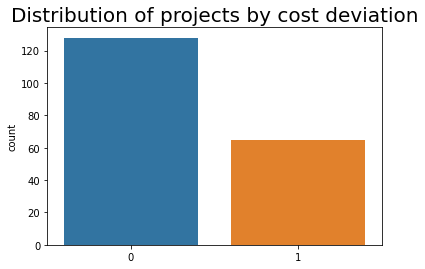

In [69]:
sns.countplot(x=y)
plt.title('Distribution of projects by cost deviation', fontsize=20)
plt.show()

In [72]:
# 1. Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Prepare pipeline
column_transformer = make_column_transformer((StandardScaler(), make_column_selector(dtype_exclude=['object'])),
                                             (OneHotEncoder(), make_column_selector(dtype_include=['object'])),
                                              remainder='passthrough')

# 3. Models
models_estimator = [LogisticRegression(solver='lbfgs', max_iter=1000),
        RidgeClassifier(alpha=0.5),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, max_features='sqrt'),
        ExtraTreeClassifier(max_depth=5, random_state=0),
        AdaBoostClassifier(n_estimators=100),
        GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1),
        XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1),
        LinearSVC(max_iter=100),
        SVC(kernel='rbf', gamma=0.1, C=10)]
models_names = ['Logistic Regression', 'Ridge', 'Decision Tree', 'Random Forest', 'Extra Tree', 
                'AdaBoost', 'Gradient Boosting', 'Xgboost', 'Linear SVC', 'SVC']

scores_models = []
for model, name in zip(models_estimator, models_names):
    pipe_model = make_pipeline(column_transformer, model)
    pipe_model.fit(X_train, y_train)
    predictions = pipe_model.predict(X_test)
    scores_models.append((name, accuracy_score(y_test, predictions), roc_auc_score(y_test, predictions),
                          precision_score(y_test, predictions), recall_score(y_test, predictions), 
                          f1_score(y_test, predictions)))

# Create a dataframe with the scores
scores_df = pd.DataFrame(scores_models, columns=['Model', 'Accuracy', 'ROC_AUC','Precision', 'Recall', 'F1 Score'])
scores_df.sort_values(by=['F1 Score'], ascending=False, inplace=True)
scores_df

/Users/hfelizzola/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model  Accuracy   ROC_AUC  Precision  Recall  F1 Score
5             AdaBoost  0.672414  0.638393   0.428571  0.5625  0.486486
9                  SVC  0.741379  0.647321   0.538462  0.4375  0.482759
8           Linear SVC  0.689655  0.630952   0.444444  0.5000  0.470588
6    Gradient Boosting  0.637931  0.595238   0.380952  0.5000  0.432432
1                Ridge  0.672414  0.599702   0.411765  0.4375  0.424242
3        Random Forest  0.706897  0.604167   0.461538  0.3750  0.413793
2        Decision Tree  0.655172  0.568452   0.375000  0.3750  0.375000
7              Xgboost  0.586207  0.520833   0.300000  0.3750  0.333333
0  Logistic Regression  0.637931  0.537202   0.333333  0.3125  0.322581
4           Extra Tree  0.551724  0.477679   0.250000  0.3125  0.277778

#### Visualization the validation for the Random Forest

In [73]:
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC, PrecisionRecallCurve

In [74]:
# Scaler X 
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[num_cols])
X_scaled = pd.DataFrame(X_scaled, columns=num_cols)
# OneHotEncoder X
cat_cols = X.select_dtypes(include=['object']).columns
X_cat_encoded = pd.get_dummies(X[cat_cols])
# Concatenate X
X_prep = pd.concat([X_scaled, X_cat_encoded], axis=1)

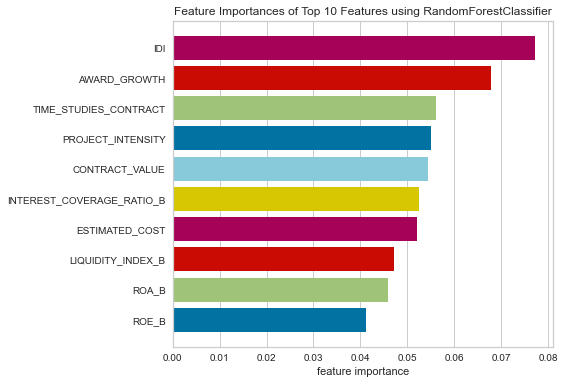

<AxesSubplot:title={'center':'Feature Importances of Top 10 Features using RandomForestClassifier'}, xlabel='feature importance'>

In [75]:
# AdaBoost
model =  RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, max_features='sqrt')
viz = FeatureImportances(model, orient='h', topn=10, relative=False)
viz.fit(X_prep, y)
viz.show()

#### Logistic Regression Analysis for cost deviation

In [76]:
import statsmodels.api as sm

In [77]:
# Select columns
col_sel = ['OTHER_SCORE',
           'DEBT_INDEX_B',
           'IDI',
           'LIQUIDITY_INDEX_B',
           'ROE_B', 
           #'ROA_B',
           'MUNICIPALITY_TYPE',
           'ADVANCED_PAYMENT',
           'CONTRACTOR','YEAR',
           'EXPERIENCE_B_VALUE',
           'NUMBER_BIDDERS',
           'HIGHEST SCORE',
           'LOWEST_SCORE',
           'ESTIMATED_COST',
           'AWARD_GROWTH']
X_prep = X[col_sel].copy()
X_prep['ONE_BIDDER'] = X_prep['NUMBER_BIDDERS'] <= 1
X_prep['ONE_BIDDER'] = X_prep['ONE_BIDDER'].astype(int)
X_prep.drop('NUMBER_BIDDERS', axis=1, inplace=True)
X_prep['LOG_ESTIMATED_COST'] = np.log(X_prep['ESTIMATED_COST'])
X_prep.drop('ESTIMATED_COST', axis=1, inplace=True)
X_prep = pd.get_dummies(X_prep, drop_first=True)

In [78]:
# Logistic Regression
X_prep = sm.add_constant(X_prep)
logit_mod_cost = sm.Logit(y, X_prep)
logit_res_cost = logit_mod_cost.fit()
print(logit_res_cost.summary())

Optimization terminated successfully.
         Current function value: 0.562728
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  193
Model:                          Logit   Df Residuals:                      171
Method:                           MLE   Df Model:                           21
Date:                Fri, 24 Jun 2022   Pseudo R-squ.:                  0.1192
Time:                        14:02:08   Log-Likelihood:                -108.61
converged:                       True   LL-Null:                       -123.30
Covariance Type:            nonrobust   LLR p-value:                    0.1048
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -6.8577      2.928     -2.342      0.019     -12.597

## 4.2.2 Machine Learning for predicting the time deviation

In [79]:
del_columns = ['COST_DEVIATION', 'ADDITIONAL_COST', 'FINAL_COST', 'ADDITIONAL_TIME', 'FINAL_DEADLINE', 'TIME_SUSPENDED_P', 'REGION_2','PERFORMANCE','DEPARTMENT','NUMBER_OF_CONTRACTS']
df_time_cat = master_data.reset_index().drop(del_columns, axis=1)

In [80]:
# Create X and y = TIME_DEVIATION
X = df_time_cat.drop('TIME_DEVIATION', axis=1)
y = [1 if i > 0 else 0 for i in df_time_cat['TIME_DEVIATION']]

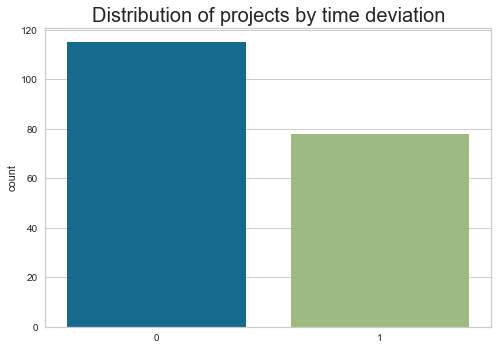

In [81]:
sns.countplot(x=y)
plt.title('Distribution of projects by time deviation', fontsize=20)
plt.show()

In [82]:
# 1. Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Prepare pipeline
column_transformer = make_column_transformer((StandardScaler(), make_column_selector(dtype_exclude=['object'])),
                                             (OneHotEncoder(), make_column_selector(dtype_include=['object'])),
                                              remainder='passthrough')

# 3. Models
models_estimator = [LogisticRegression(solver='lbfgs', max_iter=1000),
        RidgeClassifier(alpha=0.5),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, max_features='sqrt'),
        ExtraTreeClassifier(max_depth=5, random_state=0),
        AdaBoostClassifier(n_estimators=100),
        GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1),
        XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1),
        LinearSVC(max_iter=100),
        SVC(kernel='rbf', gamma=0.1, C=10)]
models_names = ['Logistic Regression', 'Ridge', 'Decision Tree', 'Random Forest', 'Extra Tree', 
                'AdaBoost', 'Gradient Boosting', 'Xgboost', 'Linear SVC', 'SVC']

scores_models = []
for model, name in zip(models_estimator, models_names):
    pipe_model = make_pipeline(column_transformer, model)
    pipe_model.fit(X_train, y_train)
    predictions = pipe_model.predict(X_test)
    scores_models.append((name, accuracy_score(y_test, predictions), roc_auc_score(y_test, predictions),
                          precision_score(y_test, predictions), recall_score(y_test, predictions), 
                          f1_score(y_test, predictions)))

# Create a dataframe with the scores
scores_df = pd.DataFrame(scores_models, columns=['Model', 'Accuracy', 'ROC_AUC','Precision', 'Recall', 'F1 Score'])
scores_df.sort_values(by=['F1 Score'], ascending=False, inplace=True)
scores_df

/Users/hfelizzola/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model  Accuracy   ROC_AUC  Precision    Recall  F1 Score
5             AdaBoost  0.655172  0.625000   0.550000  0.500000  0.523810
9                  SVC  0.637931  0.611111   0.523810  0.500000  0.511628
6    Gradient Boosting  0.620690  0.588384   0.500000  0.454545  0.476190
3        Random Forest  0.586207  0.551768   0.450000  0.409091  0.428571
8           Linear SVC  0.482759  0.486111   0.366667  0.500000  0.423077
7              Xgboost  0.568966  0.537879   0.428571  0.409091  0.418605
2        Decision Tree  0.603448  0.556818   0.470588  0.363636  0.410256
0  Logistic Regression  0.551724  0.523990   0.409091  0.409091  0.409091
1                Ridge  0.517241  0.496212   0.375000  0.409091  0.391304
4           Extra Tree  0.586207  0.516414   0.416667  0.227273  0.294118

#### Visualization the validation for the Random Forest

In [83]:
# Scaler X 
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[num_cols])
X_scaled = pd.DataFrame(X_scaled, columns=num_cols)
# OneHotEncoder X
cat_cols = X.select_dtypes(include=['object']).columns
X_cat_encoded = pd.get_dummies(X[cat_cols])
# Concatenate X
X_prep = pd.concat([X_scaled, X_cat_encoded], axis=1)

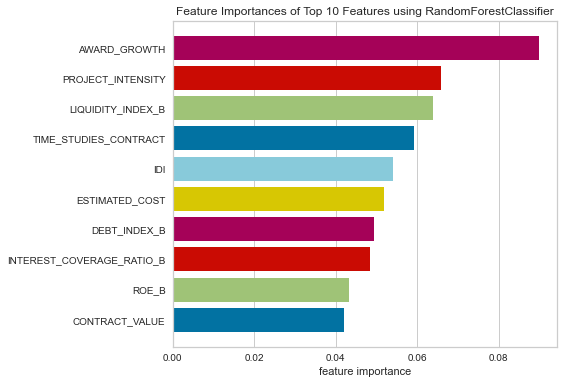

<AxesSubplot:title={'center':'Feature Importances of Top 10 Features using RandomForestClassifier'}, xlabel='feature importance'>

In [84]:
# AdaBoost
model =  RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, max_features='sqrt')
viz = FeatureImportances(model, orient='h', topn=10, relative=False)
viz.fit(X_prep, y)
viz.show()

#### Logistic Regression Analysis for cost deviation

In [156]:
import statsmodels.api as sm

In [85]:
# Select columns
col_sel = ['OTHER_SCORE',
           'DEBT_INDEX_B',
           'IDI',
           'LIQUIDITY_INDEX_B',
           #'ROE_B', 
           'ROA_B',
           'MUNICIPALITY_TYPE',
           'ADVANCED_PAYMENT',
           'CONTRACTOR',
           'YEAR',
           'EXPERIENCE_B_VALUE',
           'NUMBER_BIDDERS',
           'HIGHEST SCORE',
           'LOWEST_SCORE',
           'ESTIMATED_COST',
           'AWARD_GROWTH']
X_prep = X[col_sel].copy()
X_prep['ONE_BIDDER'] = X_prep['NUMBER_BIDDERS'] <= 1
X_prep['ONE_BIDDER'] = X_prep['ONE_BIDDER'].astype(int)
X_prep.drop('NUMBER_BIDDERS', axis=1, inplace=True)
X_prep['LOG_ESTIMATED_COST'] = np.log(X_prep['ESTIMATED_COST'])
X_prep.drop('ESTIMATED_COST', axis=1, inplace=True)
X_prep = pd.get_dummies(X_prep, drop_first=True)

In [86]:
# Logistic Regression
X_prep = sm.add_constant(X_prep)
logit_mod_cost = sm.Logit(y, X_prep)
logit_res_cost = logit_mod_cost.fit()
print(logit_res_cost.summary())

Optimization terminated successfully.
         Current function value: 0.597018
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  193
Model:                          Logit   Df Residuals:                      171
Method:                           MLE   Df Model:                           21
Date:                Fri, 24 Jun 2022   Pseudo R-squ.:                  0.1151
Time:                        14:05:06   Log-Likelihood:                -115.22
converged:                       True   LL-Null:                       -130.21
Covariance Type:            nonrobust   LLR p-value:                   0.09262
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -7.6103      2.865     -2.656      0.008     -13.226